In this implementation, we are testing an exemple of Deep Reinforcement Learning algorithm: the Deep Q-Learning.For this , we are using the CartPole environment from m OpenAI Gym, where the agent must balance a pole on a moving cart.
For this experiment, I modified a code from https://medium.com/@samina.amin/deep-q-learning-dqn-71c109586bae

In [ ]:
pip install gym torch numpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

Episode 1/300, Reward: 82.00, Epsilon: 0.99
Episode 2/300, Reward: 18.00, Epsilon: 0.98
Episode 3/300, Reward: 22.00, Epsilon: 0.97
Episode 4/300, Reward: 23.00, Epsilon: 0.96
Episode 5/300, Reward: 15.00, Epsilon: 0.95
Episode 6/300, Reward: 15.00, Epsilon: 0.94
Episode 7/300, Reward: 26.00, Epsilon: 0.93
Episode 8/300, Reward: 28.00, Epsilon: 0.92
Episode 9/300, Reward: 9.00, Epsilon: 0.91
Episode 10/300, Reward: 20.00, Epsilon: 0.90
Episode 11/300, Reward: 12.00, Epsilon: 0.90
Episode 12/300, Reward: 21.00, Epsilon: 0.89
Episode 13/300, Reward: 46.00, Epsilon: 0.88
Episode 14/300, Reward: 22.00, Epsilon: 0.87
Episode 15/300, Reward: 12.00, Epsilon: 0.86
Episode 16/300, Reward: 23.00, Epsilon: 0.85
Episode 17/300, Reward: 19.00, Epsilon: 0.84
Episode 18/300, Reward: 18.00, Epsilon: 0.83
Episode 19/300, Reward: 11.00, Epsilon: 0.83
Episode 20/300, Reward: 64.00, Epsilon: 0.82
Episode 21/300, Reward: 10.00, Epsilon: 0.81
Episode 22/300, Reward: 9.00, Epsilon: 0.80
Episode 23/300, Rewar

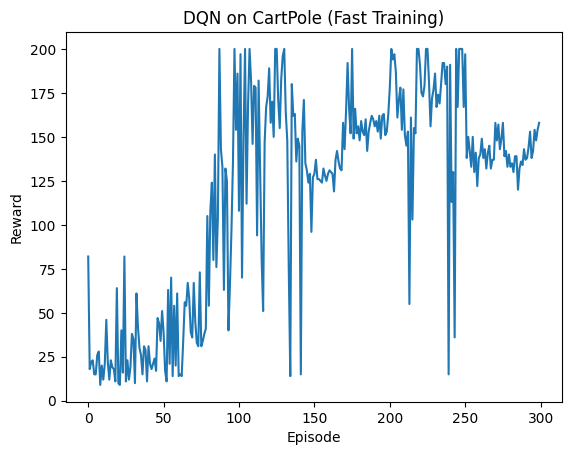

In [ ]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

################################
#        Hyperparameters       #
################################
ENV_NAME = "CartPole-v1"
EPISODES = 300             # Fewer episodes than before
MAX_STEPS = 200            # Max steps per episode (typical default for CartPole-v1)
GAMMA = 0.99               # Discount factor
LR = 1e-3                  # Learning rate
EPS_START = 1.0            # Initial epsilon for exploration
EPS_DECAY = 0.99
EPS_END = 0.01        # Epsilon decay factor
BATCH_SIZE = 32            # Smaller batch size to speed up training
MEMORY_SIZE = 2000         # Smaller replay memory
TARGET_UPDATE_FREQ = 500   # Steps between target network updates

################################
#         DQN Network          #
################################
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        # Increase the hidden size
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

################################
#       Replay Memory          #
################################
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

################################
#  Epsilon-Greedy Policy       #
################################
def select_action(state, epsilon, policy_net, env):
    if random.random() < epsilon:
        return env.action_space.sample()  # Explore
    else:
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = policy_net(state_tensor)
        return q_values.argmax().item()   # Exploit

################################
#       Optimize Model         #
################################
def optimize_model(memory, policy_net, target_net, optimizer):
    if len(memory) < BATCH_SIZE:
        return

    batch = memory.sample(BATCH_SIZE)
    state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*batch)

    state_batch = torch.FloatTensor(state_batch)
    action_batch = torch.LongTensor(action_batch).unsqueeze(1)
    reward_batch = torch.FloatTensor(reward_batch).unsqueeze(1)
    next_state_batch = torch.FloatTensor(next_state_batch)
    done_batch = torch.FloatTensor(done_batch).unsqueeze(1)

    # Current Q-values
    q_values = policy_net(state_batch).gather(1, action_batch)

    # Target Q-values using target_net
    with torch.no_grad():
        max_next_q_values = target_net(next_state_batch).max(1)[0].unsqueeze(1)
        target_q_values = reward_batch + GAMMA * max_next_q_values * (1 - done_batch)

    loss = nn.MSELoss()(q_values, target_q_values)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

################################
#       Main Training          #
################################
if __name__ == "__main__":
    env = gym.make(ENV_NAME)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    # Initialize networks
    policy_net = DQN(state_dim, action_dim)
    target_net = DQN(state_dim, action_dim)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=LR)
    memory = ReplayMemory(MEMORY_SIZE)

    epsilon = EPS_START
    steps_done = 0
    rewards_per_episode = []

    for episode in range(EPISODES):
        state = env.reset()
        total_reward = 0

        for step in range(MAX_STEPS):
            # Select action
            action = select_action(state, epsilon, policy_net, env)
            next_state, reward, done, _ = env.step(action)

            # Store transition
            memory.push(state, action, reward, next_state, float(done))

            # Move to the next state
            state = next_state
            total_reward += reward

            # Optimize the model
            optimize_model(memory, policy_net, target_net, optimizer)

            # Update target network
            if steps_done % TARGET_UPDATE_FREQ == 0:
                target_net.load_state_dict(policy_net.state_dict())

            steps_done += 1

            if done:
                break

        # Decay epsilon
        epsilon = max(EPS_END, epsilon * EPS_DECAY)

        rewards_per_episode.append(total_reward)

    env.close()

    # Plot results
    plt.plot(rewards_per_episode)
    plt.title("DQN on CartPole (Fast Training)")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.show()


nitial Learning Phase (Episodes 0–50):
The rewards are low and highly variable, indicating that the agent is in its exploration phase, gradually learning how to balance the pole.
Progressive Improvement (Episodes 50–150):
The rewards steadily increase, suggesting that the agent is developing effective policies and improving its ability to keep the pole balanced.
High Performance Achieved (Episodes 150–200):
The rewards reach near the maximum possible value (200), demonstrating that the agent has learned an optimal policy for balancing the pole.
Instability in Late Training (Episodes 200–300):
The rewards fluctuate significantly between high and low values, likely due to policy instability. This may be caused by ongoing exploration, training instability, or the agent struggling to generalize its learned strategy.